# gitからコードをclone

In [1]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 406 (delta 3), reused 5 (delta 2), pack-reused 397
Receiving objects: 100% (406/406), 7.91 MiB | 22.26 MiB/s, done.
Resolving deltas: 100% (230/230), done.


In [ ]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


# 5章・6章 RNN・LSTM

## 理論の復習

[今度こそわかるぞRNN, LSTM編](https://qiita.com/kazukiii/items/df809d6cd5d7d1f57be3)

## RNNLMの実装

### RNNLMのネットワーク図

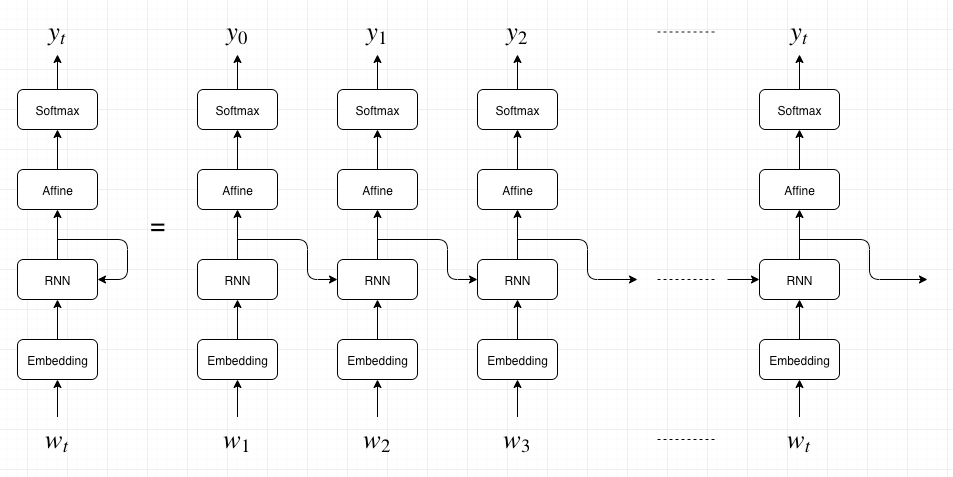

コーパスを処理するRNNの例

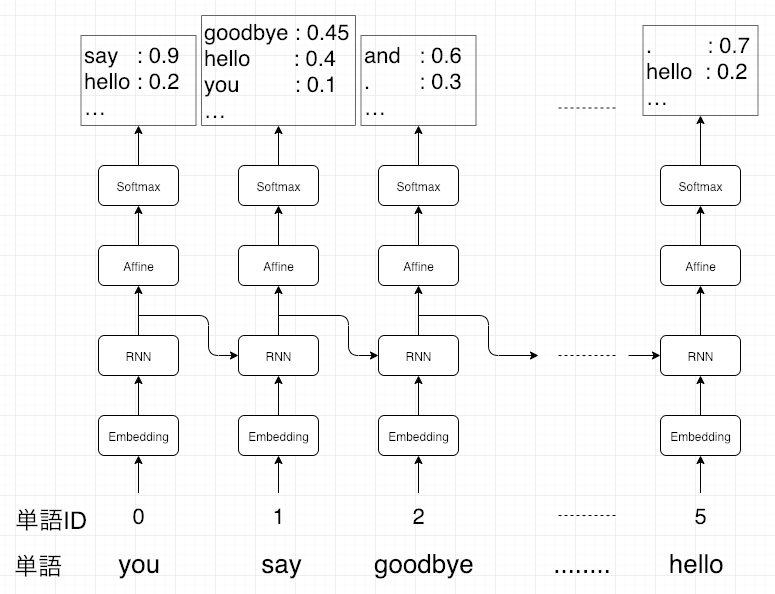

### RNNレイヤの実装


RNNレイヤの計算グラフ

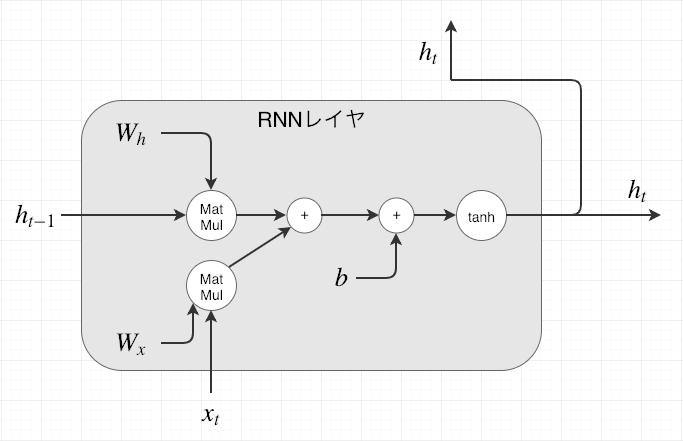

順伝播の式

$$
  \boldsymbol{h}_t = \tanh(\boldsymbol{h}_{t-1}\boldsymbol{W}_\boldsymbol{h}+\boldsymbol{x}_t\boldsymbol{W}_\boldsymbol{x}+\boldsymbol{b})
$$

RNNクラス ( common/time_layes.py )

In [ ]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    # 順伝播
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    # 逆伝播
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### TimeRNNレイヤの実装

TimeRNNレイヤはT個のRNNレイヤを連結したネットワーク ( common/time_layers.py )

In [ ]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

### RNNLMの実装

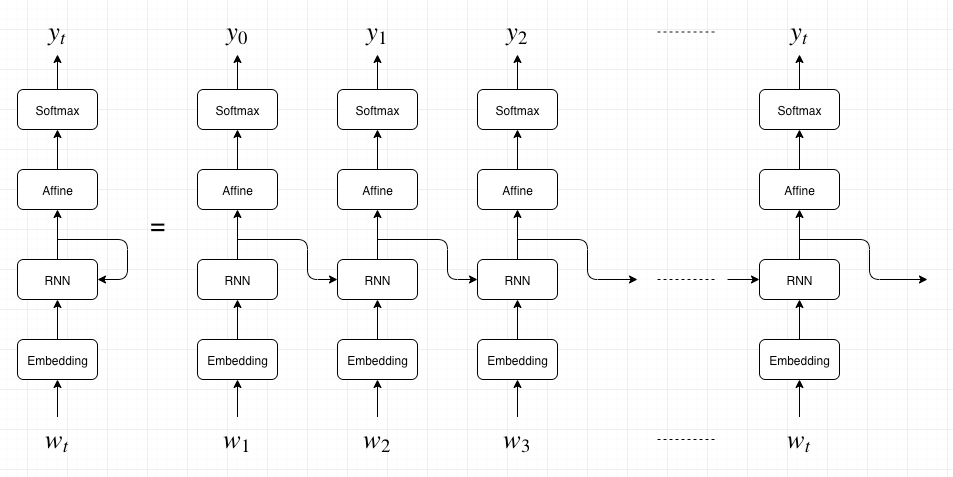

逆伝播の図

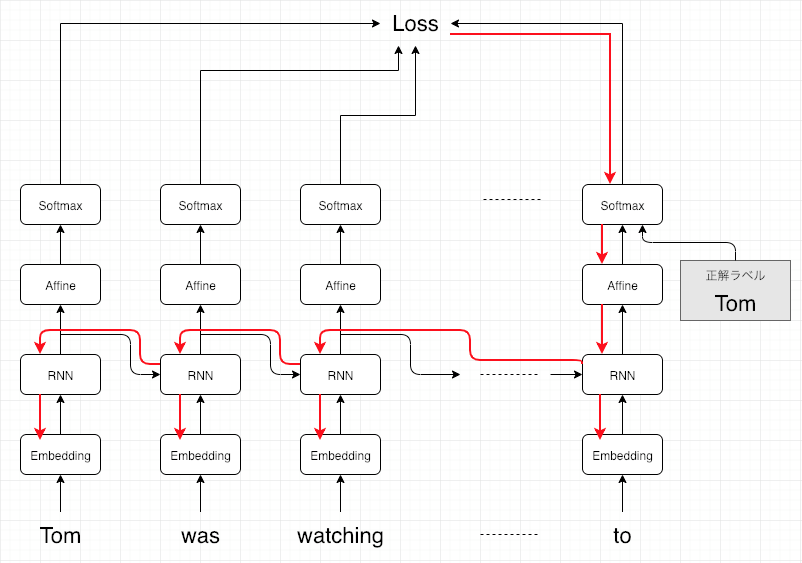

SimpleRnnlmクラスは4つのTimeレイヤを重ねたネットワーク ( ch05/simple_rnnlm.py )

In [ ]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


### RNNLMの学習

PTBデータセットの先頭1,000個の単語を利用して学習を行う。( ch05/train_custom_loop.py)

In [2]:
%cd /content/deep-learning-from-scratch-2/ch05

/content/deep-learning-from-scratch-2/ch05


In [3]:
!python3 train_custom_loop.py

Done
corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 406.54
| epoch 2 | perplexity 316.49
| epoch 3 | perplexity 238.94
| epoch 4 | perplexity 220.49
| epoch 5 | perplexity 208.62
| epoch 6 | perplexity 202.76
| epoch 7 | perplexity 198.60
| epoch 8 | perplexity 196.71
| epoch 9 | perplexity 191.74
| epoch 10 | perplexity 192.47
| epoch 11 | perplexity 188.90
| epoch 12 | perplexity 192.69
| epoch 13 | perplexity 189.76
| epoch 14 | perplexity 190.18
| epoch 15 | perplexity 189.51
| epoch 16 | perplexity 186.04
| epoch 17 | perplexity 183.44
| epoch 18 | perplexity 181.06
| epoch 19 | perplexity 181.96
| epoch 20 | perplexity 182.84
| epoch 21 | perplexity 181.65
| epoch 22 | perplexity 176.23
| epoch 23 | perplexity 174.39
| epoch 24 | perplexity 175.56
| epoch 25 | perplexity 173.76
| epoch 26 | perplexity 172.84
| epoch 27 | perplexity 168.18
| epoch 28 | perplexity 166.89
| epoch 29 | perplexity 164.32
| epoch 30 | perplexity 158.58
| epoch 31 | perplexity 159.80
| e

perplexityは確率の逆数。確率は0～1なので、perplexityは小さいほどいい予測ができているといえる。

## 改良版RNNLMの実装

### LSTMの実装

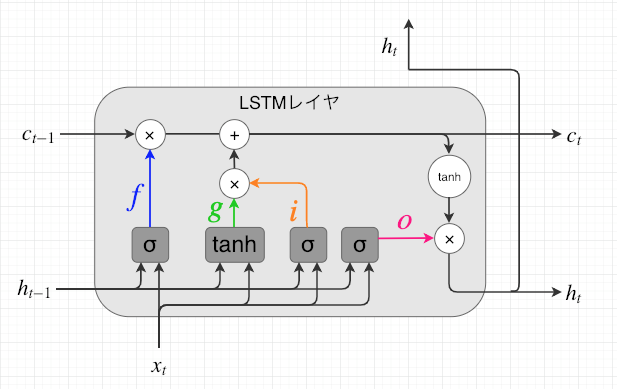

$$
  𝐟=σ(𝐱_t𝐖_𝐱^{(𝐟)}+𝐡_{t-1}𝐖_𝐡^{(𝐟)}+𝐛^{(𝐟)})
$$

$$
  𝐠=\tanh(𝐱_t𝐖_𝐱^{(𝐠)}+𝐡_{t-1}𝐖_𝐡^{(𝐠)}+𝐛^{(𝐠)})
$$

$$
  𝐢=σ(𝐱_t𝐖_𝐱^{(𝐢)}+𝐡_{t-1}𝐖_𝐡^{(𝐢)}+𝐛^{(𝐢)})
$$

$$
  𝐨=σ(𝐱_t𝐖_𝐱^{(𝐨)}+𝐡_{t-1}𝐖_𝐡^{(𝐨)}+𝐛^{(𝐨)})
$$

以上の4つの重みはまとめて処理する。

$$
  𝐜_t = 𝐟\odot𝐜_{t-1}+𝐠\odot𝐢
$$

$$
  𝐡_t = 𝐨\odot\tanh(𝐜_t)
$$

LSTMクラスを実装 ( common/time_layers.py )

In [ ]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


同じようにT個のLSTMレイヤで構成されるTimeLSTMを実装 (省略)

### 改良版RNNLMの実装&学習

元のRNNLMのTimeRNNレイヤをTimeLSTMに変えるだけ。

追加で新しいメソッドを追加。


RNNLMと同じようにPTBデータセットで学習を行う。( ch06/train_rnnlm.py )

In [4]:
%cd /content/deep-learning-from-scratch-2/ch06

/content/deep-learning-from-scratch-2/ch06


In [5]:
!python3 train_rnnlm.py

Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10001.03
| epoch 1 |  iter 21 / 1327 | time 7[s] | perplexity 2755.49
| epoch 1 |  iter 41 / 1327 | time 14[s] | perplexity 1246.38
| epoch 1 |  iter 61 / 1327 | time 22[s] | perplexity 947.50
| epoch 1 |  iter 81 / 1327 | time 29[s] | perplexity 763.64
| epoch 1 |  iter 101 / 1327 | time 36[s] | perplexity 651.60
| epoch 1 |  iter 121 / 1327 | time 44[s] | perplexity 616.93
| epoch 1 |  iter 141 / 1327 | time 51[s] | perplexity 604.47
| epoch 1 |  iter 161 / 1327 | time 58[s] | perplexity 582.64
| epoch 1 |  iter 181 / 1327 | time 66[s] | perplexity 564.26
| epoch 1 |  iter 201 / 1327 | time 73[s] | perplexity 507.56
| epoch 1 |  iter 221 / 1327 | time 80[s] | perplexity 486.11
| epoch 1 |  iter 241 / 1327 | time 87[s] | perplexity 430.11
| epoch 1 |  iter 261 / 1327 | time 94[s] | perplexity 466.59
| epoch 1 |  iter 281 / 1327 | time 102[s] | perplexity 449.57
| epoch 1 |  iter 301 / 1327 | time 109[s] | perplexity 384.18
| epo

### RNNLMのさらなる改善


*   LSTMの多層化
*   Dropout
*   重み共有

気になった方は参考書を見てください。研究室にあります。

# 7章 RNNによる文章生成

## 言語モデルを使用した文章生成

### 文章生成の実装

In [7]:
%cd /content/deep-learning-from-scratch-2/ch07

/content/deep-learning-from-scratch-2/ch07


In [8]:
!python3 generate_text.py

you 're providing to close one thing faced with the toxin.
 i 'm enormous of us out of task and feared.
 eurodollar rates are also deprived of this year that at least better than commercial 's emphasis on a high source of his exposure to its upscale discipline.
 he urged it to understand and his new partner when sophisticated rowe environmentalists do n't see a buyer of one card.
 u.s. official hill told kidder bank of atlanta.
 pinnacle west california transactions unlike nasa carpets william r. jones university chairman stewart iii meant mr. jones building


## seq2seq

### seq2seqを用いたアプリケーション

seq2seqは、「ある時系列のデータ」を「別の時系列のデータ」に変換する。

時系列データを変換するという枠組みは様々な問題に適用することができる。

*   チャットボット
*   アルゴリズムの学習
*   イメージキャプション
*   などなど



### seq2seqの原理

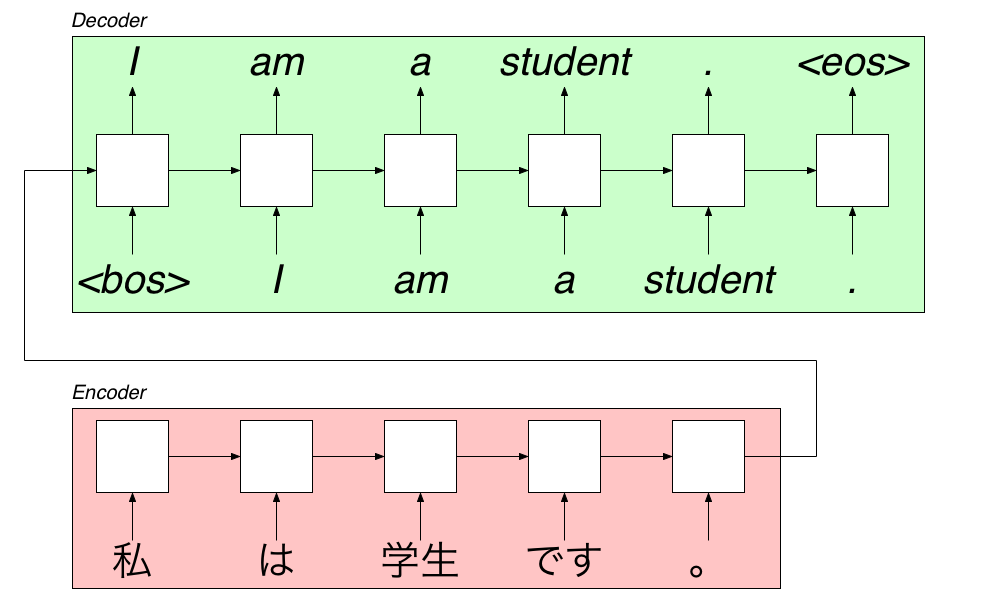

seq2seq実装にむけて、今回は「足し算」のデータセットを使用する。 ( dataset/addition.txt )

16+75  _91  

52+607 _659

75+22  _97

63+22  _85

...

## seq2seqの実装

### Encoderクラス

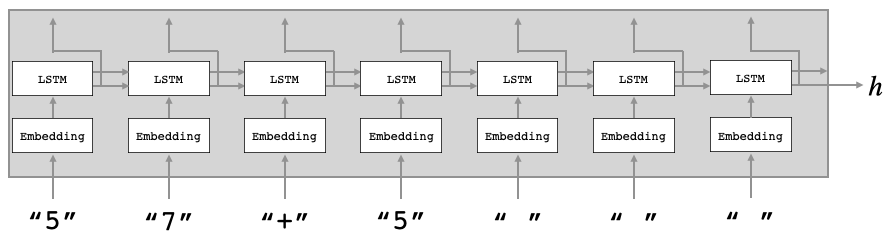

In [ ]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### Decoderクラス

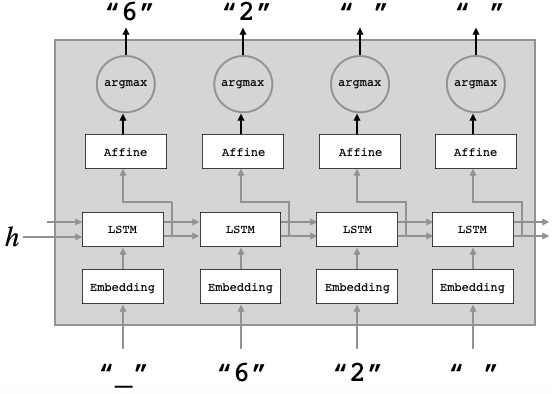

In [9]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

### seq2seqクラス

EncoderとDecoderをつなげて、softmax with lossレイヤでLossを計算する。

In [ ]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

### seq2seqの評価

In [11]:
%cd /content/deep-learning-from-scratch-2/ch07 

/content/deep-learning-from-scratch-2/ch07


In [12]:
!python3 train_seq2seq.py

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 4[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 6[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 7[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 8[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 9[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 11[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 12[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 13[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 15[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 16[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 17[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 18[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 20[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 21[s] | loss 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582

精度は10%いかないくらい。

## seq2seqの改良

### 入力データの反転(Reverse)

入力データを反転させるだけで精度が上がる

５７＋５ → ５＋７５

６２８＋５２１ → １２５＋８２６

ch07/train_seq2seq.py を開いて、


```
is_reverse = False
```
をTrueにして保存


In [14]:
!python3 train_seq2seq.py

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 3[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 4[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 6[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 7[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 8[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 9[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 11[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 12[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 13[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 14[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 16[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 17[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 18[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 19[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 21[s] | loss 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582

入力を反転するだけで精度爆上がり(50%越え)

### 覗き見(Peeky)

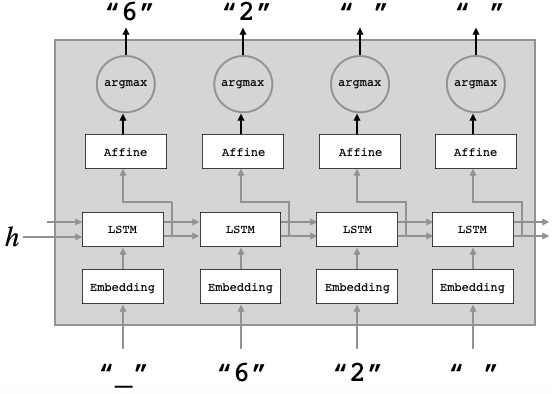

Encoderの出力𝐡には重要な情報がたっぷり詰まっている。

すべてのLSTMレイヤとAffineレイヤにEncoderの出力𝐡を与える。

ch07/train_seq2seq.pyを開いて、モデルをPeekySeq2seqに変更する。

ReverseはTrueのままでOK

```
# model = Seq2seq(...)
model = PeekySeq2seq(...)
```



Reverse + Peeky モデル

In [16]:
!python3 train_seq2seq.py

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 1[s] | loss 2.48
| epoch 1 |  iter 41 / 351 | time 2[s] | loss 2.20
| epoch 1 |  iter 61 / 351 | time 4[s] | loss 1.99
| epoch 1 |  iter 81 / 351 | time 5[s] | loss 1.89
| epoch 1 |  iter 101 / 351 | time 6[s] | loss 1.82
| epoch 1 |  iter 121 / 351 | time 8[s] | loss 1.82
| epoch 1 |  iter 141 / 351 | time 9[s] | loss 1.80
| epoch 1 |  iter 161 / 351 | time 11[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 12[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 14[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 15[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 16[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 18[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 19[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 21[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 22[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 23[s] | loss 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 58

精度すごい上がった！100%目前！

# 8章 Attention

どの入力単語に注目してDecodeしているのか？ということに注意しながら学習するモデル

## seq2seqの問題点

seq2seqのEncoderの出力は「固定長のベクトル」だった。

どんなに長い入力文でも固定長のベクトルに変換しなければならないので、必要な情報がベクトルからはみ出てしまう。

## Attentionの仕組み

### Encoderの改良

LSTMレイヤの最後の隠れ状態だけをDecoderに渡していた。

⇒ すべての時刻のLSTMレイヤの隠れ状態ベクトルを利用する！

### Decoderの改良

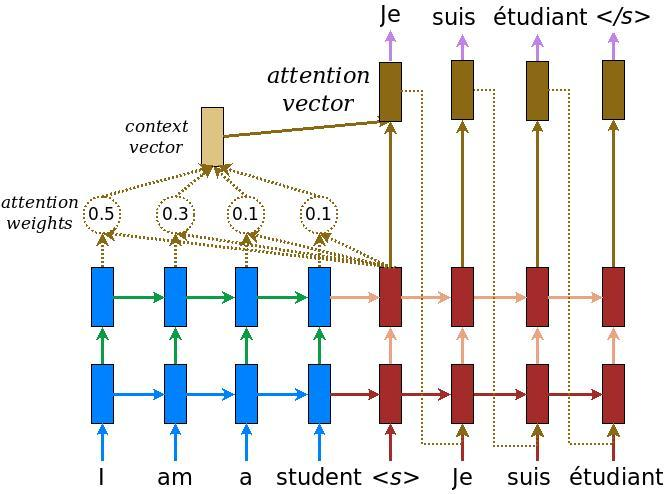